---
title: "theory"
execute:
  # echo: false
  freeze: auto  # re-render only when source changes
format:
  html:
    code-fold: true
    code-summary: "Show the code"
---

You might remember that even before this course started, I gave you an [example](/basics/example.ipynb) of how to load data with pandas and how to plot it. Here we will be using the same data, namely, a time series for atmospheric CO$_2$ measured throughout the years in an obesevatory in Hawaii.

In [29]:
#| code-summary: "import stuff"
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()  # datetime converter for a matplotlib
import seaborn as sns
sns.set(style="ticks", font_scale=1.5)
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from datetime import datetime as dt
import time
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
# %matplotlib widget

In [2]:
#| code-summary: "load csv and process data"
url = "https://gml.noaa.gov/webdata/ccgg/trends/co2/co2_weekly_mlo.csv"
# df = pd.read_csv(url, header=47, na_values=[-999.99])

# you can first download, and then read the csv
filename = "co2_weekly_mlo.csv"
df = pd.read_csv(filename,
                 comment='#',  # will ignore rows starting with #
                 na_values=[-999.99]  # substitute -999.99 for NaN (Not a Number), data not available
                 )
df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.set_index('date')
# there are too many unnecessary columns, let's keep only co2 concentration (ppm)
df = df['average'].to_frame().rename(columns={'average': 'co2'})
# data comes in weekly frequency, let's make it daily and fill gaps with linear interpolation
df = df.resample('D').interpolate(method='linear')

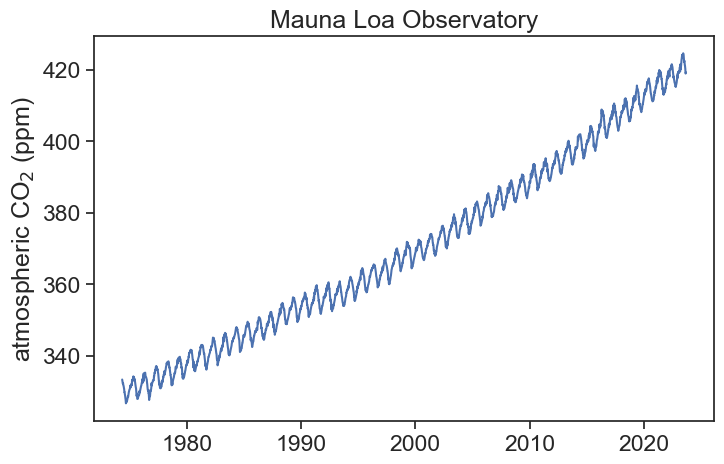

In [5]:
#| code-summary: "plot"
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(df['co2'])
ax.set(ylabel=r'atmospheric CO$_2$ (ppm)',
       title="Mauna Loa Observatory");

We can use `statsmodels.tsa.seasonal.seasonal_decompose` decompose this time series.

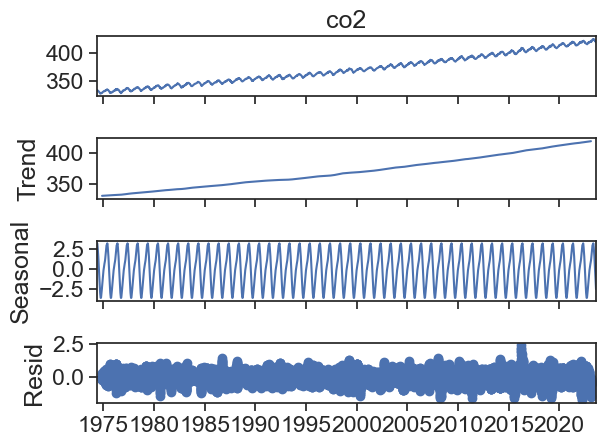

In [7]:
#| code-fold: false
result = seasonal_decompose(df['co2'], period=365)
result.plot();

The default plot is a bit ugly, we can make it better.

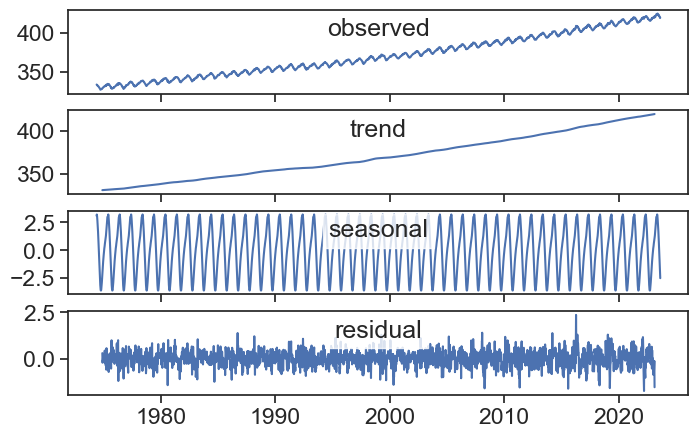

In [19]:
#| code-summary: "plot again"
fig, ax = plt.subplots(4,1, figsize=(8,5), sharex=True)
ax[0].plot(result.observed)
ax[0].text(0.5, 0.9, "observed", bbox=dict(facecolor='white', alpha=0.8),
           transform=ax[0].transAxes, ha='center', va='top')
ax[1].plot(result.trend)
ax[1].text(0.5, 0.9, "trend", bbox=dict(facecolor='white', alpha=0.8),
           transform=ax[1].transAxes, ha='center', va='top')
ax[2].plot(result.seasonal)
ax[2].text(0.5, 0.9, "seasonal", bbox=dict(facecolor='white', alpha=0.8),
           transform=ax[2].transAxes, ha='center', va='top')
ax[3].plot(result.resid)
ax[3].text(0.5, 0.9, "residual", bbox=dict(facecolor='white', alpha=0.8),
           transform=ax[3].transAxes, ha='center', va='top');

## additive model
`seasonal_decompose` returns an object with four components:

* observed: $Y(t)$
* trend: $T(t)$
* seasonal: $S(t)$
* resid: $e(t)$

The default assumption is that the various components are **summed** together to produce the original observed time series:
$$
Y(t) = T(t) + S(t) + e(t)
$$

This is called the additive model of seasonal decomposition.

## multiplicative model
`seasonal_decompose` returns an object with four components:

Not all time series seem to behave well when decomposed assuming an additive model. See, for instance, the famous time series for passengers of a US airline between 1949 to 1960.

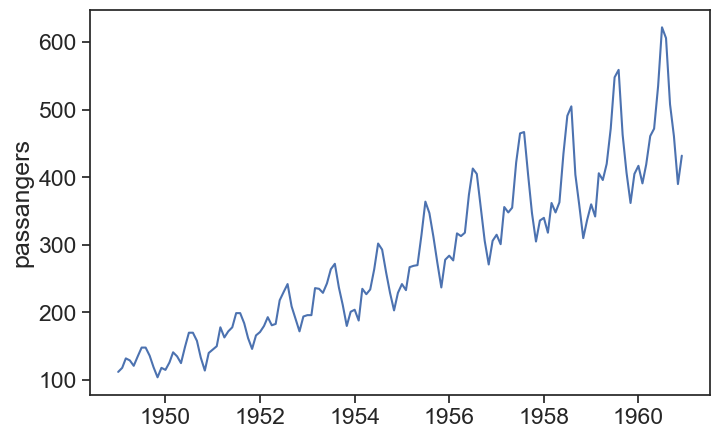

In [26]:
df_air = pd.read_csv("airline-passengers.csv")
df_air['date'] = pd.to_datetime(df_air['Month'], format='%Y-%m')
df_air = df_air.set_index('date')

fig, ax = plt.subplots(figsize=(8,5))
ax.plot(df_air['Passengers'])
ax.set(ylabel='passangers');

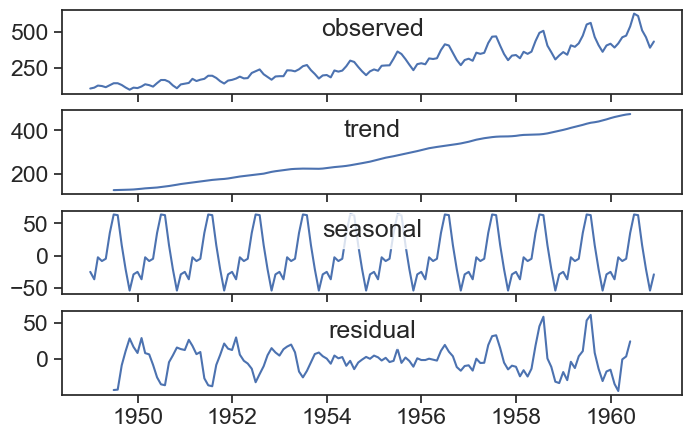

In [32]:
#| code-summary: "plot"
result = seasonal_decompose(df_air['Passengers'], period=12)

fig, ax = plt.subplots(4,1, figsize=(8,5), sharex=True)
ax[0].plot(result.observed)
ax[0].text(0.5, 0.9, "observed", bbox=dict(facecolor='white', alpha=0.8),
           transform=ax[0].transAxes, ha='center', va='top')
ax[1].plot(result.trend)
ax[1].text(0.5, 0.9, "trend", bbox=dict(facecolor='white', alpha=0.8),
           transform=ax[1].transAxes, ha='center', va='top')
ax[2].plot(result.seasonal)
ax[2].text(0.5, 0.9, "seasonal", bbox=dict(facecolor='white', alpha=0.8),
           transform=ax[2].transAxes, ha='center', va='top')
ax[3].plot(result.resid)
ax[3].text(0.5, 0.9, "residual", bbox=dict(facecolor='white', alpha=0.8),
           transform=ax[3].transAxes, ha='center', va='top');

The residual is much larger at the beginning and at the end, and this is probably because the seasonal component increases with time.
A good way to overcome this is to use the multiplicative model for seasonal decomposition:

$$
Y(t) = T(t) \times S(t) \times e(t)
$$

The components are now **multiplied** together to yield the observed time series. Let's test it:

In [43]:
result = seasonal_decompose(df_air['Passengers'], period=12, model="multiplicative")

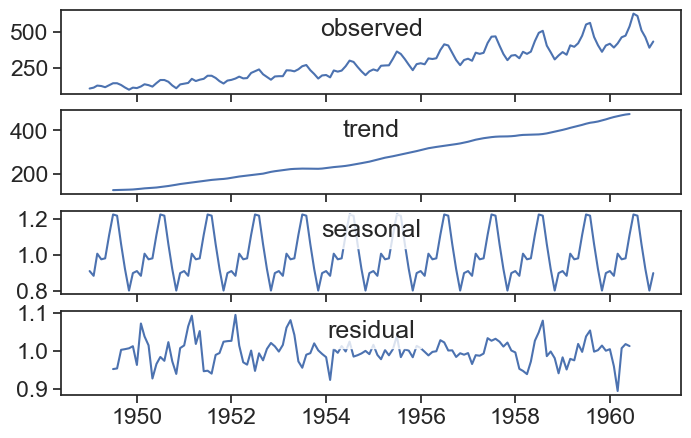

In [44]:
#| code-summary: "plot"
fig, ax = plt.subplots(4,1, figsize=(8,5), sharex=True)
ax[0].plot(result.observed)
ax[0].text(0.5, 0.9, "observed", bbox=dict(facecolor='white', alpha=0.8),
           transform=ax[0].transAxes, ha='center', va='top')
ax[1].plot(result.trend)
ax[1].text(0.5, 0.9, "trend", bbox=dict(facecolor='white', alpha=0.8),
           transform=ax[1].transAxes, ha='center', va='top')
ax[2].plot(result.seasonal)
ax[2].text(0.5, 0.9, "seasonal", bbox=dict(facecolor='white', alpha=0.8),
           transform=ax[2].transAxes, ha='center', va='top')
ax[3].plot(result.resid)
ax[3].text(0.5, 0.9, "residual", bbox=dict(facecolor='white', alpha=0.8),
           transform=ax[3].transAxes, ha='center', va='top');

## STL

STL stands for "Seasonal and Trend decomposition using LOESS". LOESS, in turn means "locally estimated scatterplot smoothing", and it is simply another name for the Savitzky-Golay smoothing filter we saw earlier in this course.